In [11]:
from qick import *
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


C:\Users\qcduser\anaconda3\envs\QCDLabs\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\qcduser\anaconda3\envs\QCDLabs\Lib\site-packages\IPython\core\magics\pylab.py:162: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [12]:
import numpy as np
from numpy.polynomial import Polynomial
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

import xarray as xr

In [13]:
import os
import sys
sys.path.insert(0, '../pattern/')

In [14]:
%load_ext autoreload
%autoreload 1

%aimport xilinx_qick.class_drx
from xilinx_qick.class_drx import drx

%aimport xilinx_qick.class_rox
from xilinx_qick.class_rox import rox

In [15]:
from qick.pyro import make_proxy
soc, soccfg = make_proxy(ns_host="10.0.100.21", ns_port=8888, proxy_name="rfsoc4x2_1")
print(soccfg)

Pyro.NameServer PYRO:Pyro.NameServer@0.0.0.0:8888
rfsoc4x2_1 PYRO:obj_c8f18a950e0549349890a51d4af531c9@10.0.100.21:46551
QICK running on RFSoC4x2, software version 0.2.381

Firmware configuration (built Wed Sep  6 18:49:29 2023):

	Global clocks (MHz): tProc dispatcher timing 409.600, RF reference 491.520
	Groups of related clocks: [tProc clock, DAC tile 0], [DAC tile 2], [ADC tile 0]

	2 signal generator channels:
	0:	axis_signal_gen_v6 - fs=9830.400 Msps, fabric=614.400 MHz
		envelope memory: 65536 complex samples (6.667 us)
		32-bit DDS, range=9830.400 MHz
		DAC tile 0, blk 0 is DAC_B
	1:	axis_signal_gen_v6 - fs=9830.400 Msps, fabric=614.400 MHz
		envelope memory: 65536 complex samples (6.667 us)
		32-bit DDS, range=9830.400 MHz
		DAC tile 2, blk 0 is DAC_A

	2 readout channels:
	0:	axis_readout_v2 - configured by PYNQ
		fs=4423.680 Msps, decimated=552.960 MHz, 32-bit DDS, range=4423.680 MHz
		axis_avg_buffer v1.0 (no edge counter, no weights)
		memory 16384 accumulated, 1024 decima

In [16]:
class PulseSequence(AveragerProgram):
    def initialize_phases(self):
        self.phase_ref_q1 = 0

    def play_seq(self):
        cfg = self.cfg
        for dr_name in self.dr_names:
            dr = cfg[dr_name]
            for waveform in dr.waveforms:
#                 print('xx', dr.dr_ch,
#                       dr.frequency_cyl,
#                       dr.maxv,
#                       waveform.name)

                self.set_pulse_registers(ch=dr.dr_ch,
                                         freq=dr.frequency_cyl,
                                         phase=0,
                                         gain=dr.maxv,
                                         waveform=waveform.name,
                                         phrst=0,
                                         mode="oneshot")
                self.pulse(ch=dr.dr_ch)

        #modified sync_all with only DAC clocks, no ADC clocks
        self.synci(self.us2cycles(0.01))

    def initialize(self):
        cfg = self.cfg
        self.dr_names = []
        self.ro_chns = []

        for val_key, val_x in cfg.items():
            if val_key[:3] == 'dr_':
                self.dr_names.append(val_key)
                self.declare_gen(ch=val_x.dr_ch, nqz=1)
                self.default_pulse_registers(ch=val_x.dr_ch,
                                             style='arb')

            elif val_key[:3] == 'ro_':
#                 print('x', val_x.ro_ch, val_x.frequency)
                self.ro_chns.append(val_x.ro_ch)
                self.declare_readout(ch=val_x.ro_ch,
                                 length=val_x.length_cyl,
                                 freq=val_x.frequency,
                                 gen_ch=val_x.dr_ch)

        for dr_name in self.dr_names:
            dr = cfg[dr_name]
            for waveform in dr.waveforms:
#                 print(waveform.name, waveform.i_data, waveform.q_data)
                self.add_pulse(ch=dr.dr_ch,
                               name=waveform.name,
                               idata=waveform.i_data,
                               qdata=waveform.q_data)

        self.trigger(ddr4=cfg['ddr4'],
                     mr=cfg['mr'],
                     adc_trig_offset=self.us2cycles(self.cfg["adc_trig_offset"]))


        self.synci(1000)  # give processor some time to configure pulses

    def body(self):
        cfg = self.cfg
        self.trigger(adcs=self.ro_chns,
                     pins=[0],
                     adc_trig_offset=self.us2cycles(self.cfg["adc_trig_offset"]))

        self.initialize_phases()
        self.play_seq()
        self.wait_all()
        self.sync_all(self.us2cycles(self.cfg["relax_delay"]))

    #%% helper
    def number2dbm(self, number):
        return 18.63 * np.log10(number) - 63.53

    def acquire_decimated(self, soc, load_pulses=True, progress=True):
        cfg = self.cfg
        iq_list = super().acquire_decimated(soc, load_pulses=load_pulses, progress=progress)
        iq_dims = np.shape(iq_list)
        res_data = xr.DataArray(iq_list,
                                coords = [np.array(['I','Q']), 1+np.arange(0, iq_dims[1], 1), np.arange(0, iq_dims[2],1)],
                                dims = ["quadrature", "rox", "ticks"],
                                name = "IQ decimated")

        return res_data



In [17]:
import xarray as xr

In [18]:
# Plot function

def plot_2q(iq_data):
    fig, axs = plt.subplots(len(iq_data.rox),dpi=200)
    for chn, iq in enumerate(iq_list):
        axs[chn].set_title("Qubit %d" % (ro_chns[chn]+1))
        axs[chn].plot(1000*soc.cycles2us(np.arange(0,len(iq[0])),ro_ch=ro_chns[chn]),
                     iq[0], label="I value, ADC %d" % (ro_chns[chn]))
        axs[chn].plot(1000*soc.cycles2us(np.arange(0,len(iq[0])),ro_ch=ro_chns[chn]),
                     iq[1], label="Q value, ADC %d" % (ro_chns[chn]))
        axs[chn].plot(1000*soc.cycles2us(np.arange(0,len(iq[0])),ro_ch=ro_chns[chn]),
                     np.abs(iq[0] + 1j * iq[1]), label="mag, ADC %d" % (ro_chns[chn]))
        axs[chn].legend(loc=1, prop={'size': 6})
        axs[chn].set_ylabel("a.u.")
        axs[chn].xaxis.set_major_locator(MultipleLocator(1000*5*soc.cycles2us(4, gen_ch = 0)))
        axs[chn].grid(which='major', color='#CCCCCC', linestyle='--')
        axs[chn].xaxis.set_major_formatter(mtick.FormatStrFormatter('%.1f'))
        axs[chn].tick_params(axis='x', rotation=45)

    plt.xlabel('ns')
    plt.tight_layout()

In [19]:
config = {"adc_trig_offset": 0.2,
          "reps": 1,
          "soft_avgs": 1,
          "expts": 1,
          "relax_delay": 1,
          "ddr4": False, # full decimated data
          "mr": False # dds data
         }

In [20]:
dr_qubit = drx(soc=soccfg, dr_ch=0, ro_ch=0, frequency=3000, gain=1, phase=0, delay=0, sleep=0)
dr_qubit.add_waveform(name='x1', t_data=[0,0.1,0.2, 0.3, 0.4], s_data=[0,1,2,1,0], idx=-1, interp_order=3)
dr_qubit.add_waveform(name='x2', t_data=[0,0.1,0.2, 0.3, 0.4], s_data=[0j,1j,2j,1j,0j], idx=-1, interp_order=3)
config['dr_qubit'] = dr_qubit

In [21]:
dr_readout = drx(soc=soccfg, dr_ch=1, ro_ch=1, frequency=3000, gain=1, phase=0, delay=0, sleep=0)
dr_readout.add_waveform(name='y1', t_data=[0,0.1,0.2,0.3,0.4], s_data=[0j,1j,2j,1j,0j], idx=-1, interp_order=3)
dr_readout.add_waveform(name='y2', t_data=[0,0.1,0.2,0.3,0.4], s_data=[0,1,2,1,0], idx=-1, interp_order=3)
config['dr_readout'] = dr_readout

In [22]:
ro_qubit = rox(soc=soccfg, dr_ch=0, ro_ch=0, frequency=3000, length=1, delay=0, sleep=0)
config['ro_qubit'] = ro_qubit

In [23]:
ro_readout = rox(soc=soccfg, dr_ch=1, ro_ch=1, frequency=3000, length=1, delay=0, sleep=0)
config['ro_readout'] = ro_readout

In [24]:
prog = PulseSequence(soccfg, config)
soc.reset_gens()  # clear any DC or periodic values on generators
iq_data = prog.acquire_decimated(soc, load_pulses=True, progress=False)

In [25]:
iq_data.to_zarr('test1.zarr', mode='w')

C:\Users\qcduser\anaconda3\envs\QCDLabs\Lib\site-packages\zarr\core\dtype\npy\string.py:249: UnstableSpecificationWarning: The data type (FixedLengthUTF32(length=1, endianness='little')) does not have a Zarr V3 specification. That means that the representation of arrays saved with this data type may change without warning in a future version of Zarr Python. Arrays stored with this data type may be unreadable by other Zarr libraries. Use this data type at your own risk! Check https://github.com/zarr-developers/zarr-extensions/tree/main/data-types for the status of data type specifications for Zarr V3.
  v3_unstable_dtype_warning(self)
C:\Users\qcduser\anaconda3\envs\QCDLabs\Lib\site-packages\zarr\api\asynchronous.py:247: ZarrUserWarning: Consolidated metadata is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  warnings.warn(


In [26]:
import xarray as xr
import matplotlib.pyplot as plt

In [27]:
with xr.open_zarr("test1.zarr") as f:
    iq_data = f['IQ decimated']

In [28]:
iq_data.data

array([[[ 1.,  1.,  2., ..., -1.,  0.,  2.],
        [ 0.,  2.,  1., ...,  0.,  1.,  3.]],

       [[ 0.,  1.,  0., ..., -1.,  0.,  0.],
        [-1.,  0.,  0., ..., -2., -1.,  1.]]])

In [29]:
def plot_2q(iq_data):
    fig, axs = plt.subplots(iq_data.rox.size,dpi=200)
    for idx in range(iq_data.rox.size):
        chn = iq_data.rox[idx]
        axs[idx].set_title("Qubit %d" % (chn+1))
        axs[idx].plot(1000*soc.cycles2us(np.arange(0,iq_data.ticks.size),ro_ch=chn),
                     iq_data.sel(rox=chn, quadrature='I'), label="I value, ADC %d" % (chn))
        axs[idx].plot(1000*soc.cycles2us(np.arange(0,iq_data.ticks.size),ro_ch=chn),
                     iq_data.sel(rox=chn, quadrature='Q'), label="Q value, ADC %d" % (chn))
        axs[idx].plot(1000*soc.cycles2us(np.arange(0,iq_data.ticks.size),ro_ch=chn),
                     np.abs(iq_data.sel(rox=chn, quadrature='I')+1j*iq_data.sel(rox=chn, quadrature='Q')), label="abs value, ADC %d" % (chn))
        axs[idx].legend(loc=1, prop={'size': 6})
        axs[idx].set_ylabel("a.u.")
        axs[idx].xaxis.set_major_locator(MultipleLocator(1000*5*soc.cycles2us(4, gen_ch = 0)))
        axs[idx].grid(which='major', color='#CCCCCC', linestyle='--')
        axs[idx].xaxis.set_major_formatter(mtick.FormatStrFormatter('%.1f'))
        axs[idx].tick_params(axis='x', rotation=45)

    plt.xlabel('ns')
    plt.tight_layout()

Traceback (most recent call last):
  File "C:\Users\qcduser\anaconda3\envs\QCDLabs\Lib\site-packages\IPython\core\interactiveshell.py", line 3508, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\qcduser\AppData\Local\Temp\ipykernel_16992\225275165.py", line 1, in <module>
    plot_2q(iq_data)
  File "C:\Users\qcduser\AppData\Local\Temp\ipykernel_16992\3219131781.py", line 6, in plot_2q
    axs[idx].plot(1000*soc.cycles2us(np.arange(0,iq_data.ticks.size),ro_ch=chn),
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\qcduser\anaconda3\envs\QCDLabs\Lib\site-packages\Pyro4\core.py", line 185, in __call__
    return self.__send(self.__name, args, kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\qcduser\anaconda3\envs\QCDLabs\Lib\site-packages\Pyro4\core.py", line 476, in _pyroInvoke
    raise data  # if you see this in your traceback, you should probably inspect the remote traceback as

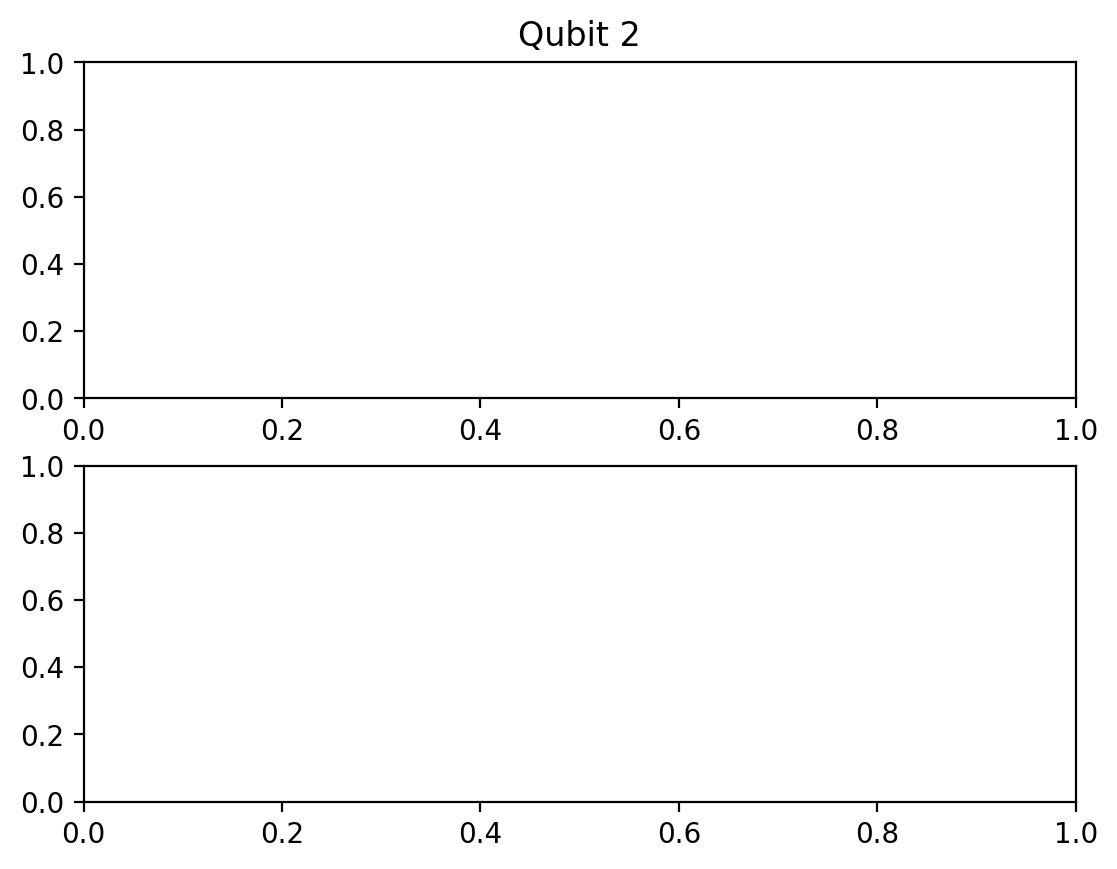

In [30]:
plot_2q(iq_data)